In [61]:
import polars as pl
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import statistics
import more_itertools as mit

In [2]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()

In [3]:
df = pl.read_csv(TRAIN_FILE_PATH)
df


id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
i64,i64,str,i64,str,i64,i64,str,i64,i64,str,i64,i64,i64,str,i64,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,36,"""Travel_Frequen...",599,"""Research & Dev...",24,3,"""Medical""",1,4,"""Male""",42,3,1,"""Laboratory Tec...",4,"""Married""",2596,5099,1,"""Y""","""Yes""",13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,"""Travel_Rarely""",921,"""Sales""",8,3,"""Other""",1,1,"""Male""",46,3,1,"""Sales Represen...",1,"""Married""",2899,10778,1,"""Y""","""No""",17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,"""Travel_Rarely""",718,"""Sales""",26,3,"""Marketing""",1,3,"""Male""",80,3,2,"""Sales Executiv...",4,"""Divorced""",4627,16495,0,"""Y""","""No""",17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,"""Travel_Rarely""",1488,"""Research & Dev...",2,3,"""Medical""",1,3,"""Female""",40,3,2,"""Healthcare Rep...",1,"""Married""",5347,13384,3,"""Y""","""No""",14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,"""Travel_Rarely""",1017,"""Research & Dev...",5,4,"""Medical""",1,2,"""Female""",37,3,5,"""Manager""",1,"""Single""",19033,19805,1,"""Y""","""Yes""",13,3,3,80,0,31,0,3,31,14,4,10,1
5,27,"""Travel_Rarely""",566,"""Research & Dev...",2,3,"""Other""",1,3,"""Female""",56,3,2,"""Manufacturing ...",2,"""Single""",4197,7103,5,"""Y""","""No""",11,3,4,80,0,6,0,3,1,0,1,0,0
6,34,"""Travel_Rarely""",944,"""Research & Dev...",10,4,"""Medical""",1,2,"""Male""",36,3,1,"""Laboratory Tec...",1,"""Single""",1281,16900,1,"""Y""","""No""",13,3,1,80,0,1,2,3,1,0,0,0,0
7,40,"""Travel_Rarely""",1009,"""Research & Dev...",2,3,"""Life Sciences""",1,4,"""Male""",74,3,1,"""Laboratory Tec...",4,"""Divorced""",3067,12916,2,"""Y""","""No""",12,3,4,80,1,6,3,2,3,2,1,2,0
8,51,"""Travel_Frequen...",1297,"""Sales""",6,3,"""Life Sciences""",1,4,"""Male""",43,1,2,"""Sales Executiv...",4,"""Married""",6439,21221,8,"""Y""","""Yes""",13,3,1,80,1,18,3,3,16,14,4,9,0


In [4]:
df.null_count()

id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
def plot_counts(column_name: str) -> None:
    grouped_df = df.groupby([column_name]).agg(
        [
            pl.count().alias("count"),
            (
                pl.col("Attrition").filter(
                    pl.col("Attrition") == 1
                ).count() / pl.count()
            ).alias("positive_factor"),
            (
                pl.col("Attrition").filter(
                    pl.col("Attrition") == 0
                ).count() / pl.count()
            ).alias("negative_factor"),
        ]
    ).sort(["count"])
    # create side by side plots
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    indices = np.arange(len(grouped_df))
    bars = left_ax.barh(indices, grouped_df['count'])
    left_ax.set_yticks(indices, grouped_df[column_name])
    left_ax.bar_label(bars, fmt='%d')

    right_ax.barh(indices, grouped_df['negative_factor'], color='b', label='negative')
    right_ax.barh(indices, grouped_df['positive_factor'], left=grouped_df['negative_factor'], color='r', label='positive')
    right_ax.legend()

    plt.title(f"Counts for {column_name}")


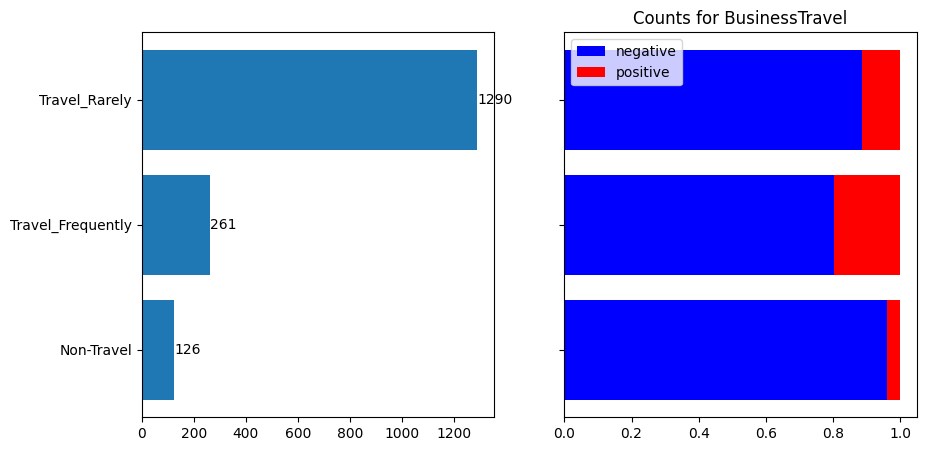

In [30]:
plot_counts('BusinessTravel')

In [82]:
df.select(pl.col('StockOptionLevel').n_unique())

StockOptionLevel
u32
4


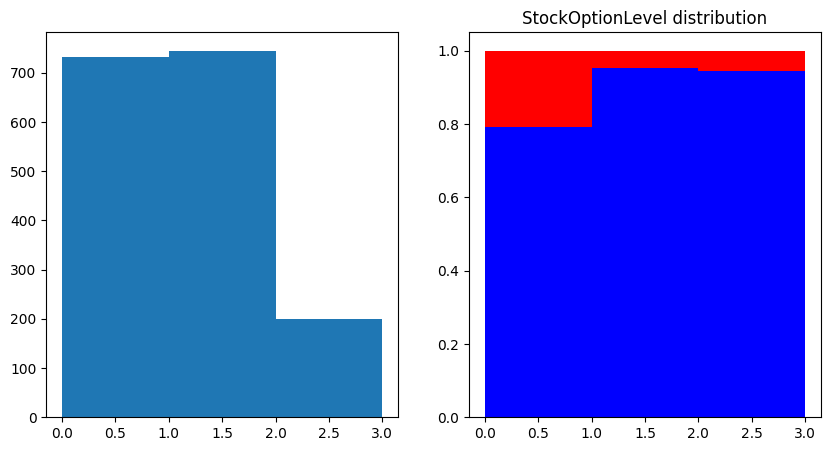

In [80]:
plot_histogram('StockOptionLevel', bins=3)

In [83]:
def plot_histogram(column_name: str, bins: int | None = None) -> None:
    if bins is None:
        # automatically adjust the number of bins
        n_unique_values = df.select(pl.col('StockOptionLevel').n_unique()).item()
        bins = min(n_unique_values, 20)

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5))
    total_series = df[column_name]
    neg_series = df.filter(pl.col('Attrition') == 0)[column_name]
    pos_series = df.filter(pl.col('Attrition') == 1)[column_name]
    (hist, brackets, _) = left_ax.hist(total_series, bins=bins)
    pos_hist, _ = np.histogram(pos_series, bins=brackets)
    neg_hist, _ = np.histogram(neg_series, bins=brackets)
    pos_factor = pos_hist / hist
    neg_factor = neg_hist / hist

    x = list(map(statistics.mean, mit.sliding_window(brackets, 2)))
    bracket_width = brackets[1] - brackets[0]
    right_ax.bar(x, neg_factor, width=bracket_width, color='b', label='negative')
    right_ax.bar(x, pos_factor, width=bracket_width, color='r', label='positive', bottom=neg_factor)

    plt.title(f'{column_name} distribution')

In [84]:
plot_histogram('TotalWorkingYears')

TypeError: 'int' object is not callable

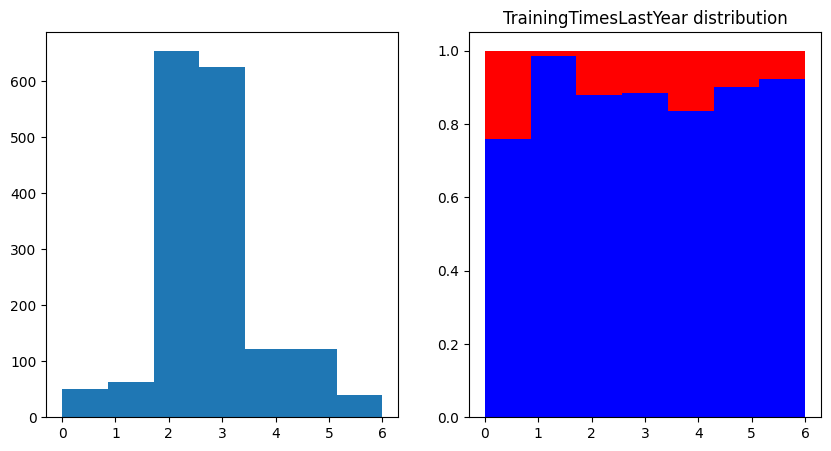

In [75]:
plot_histogram('TrainingTimesLastYear', bins=7)

In [76]:
dict(zip(df.columns, df.dtypes))

{'id': Int64,
 'Age': Int64,
 'BusinessTravel': Utf8,
 'DailyRate': Int64,
 'Department': Utf8,
 'DistanceFromHome': Int64,
 'Education': Int64,
 'EducationField': Utf8,
 'EmployeeCount': Int64,
 'EnvironmentSatisfaction': Int64,
 'Gender': Utf8,
 'HourlyRate': Int64,
 'JobInvolvement': Int64,
 'JobLevel': Int64,
 'JobRole': Utf8,
 'JobSatisfaction': Int64,
 'MaritalStatus': Utf8,
 'MonthlyIncome': Int64,
 'MonthlyRate': Int64,
 'NumCompaniesWorked': Int64,
 'Over18': Utf8,
 'OverTime': Utf8,
 'PercentSalaryHike': Int64,
 'PerformanceRating': Int64,
 'RelationshipSatisfaction': Int64,
 'StandardHours': Int64,
 'StockOptionLevel': Int64,
 'TotalWorkingYears': Int64,
 'TrainingTimesLastYear': Int64,
 'WorkLifeBalance': Int64,
 'YearsAtCompany': Int64,
 'YearsInCurrentRole': Int64,
 'YearsSinceLastPromotion': Int64,
 'YearsWithCurrManager': Int64,
 'Attrition': Int64}

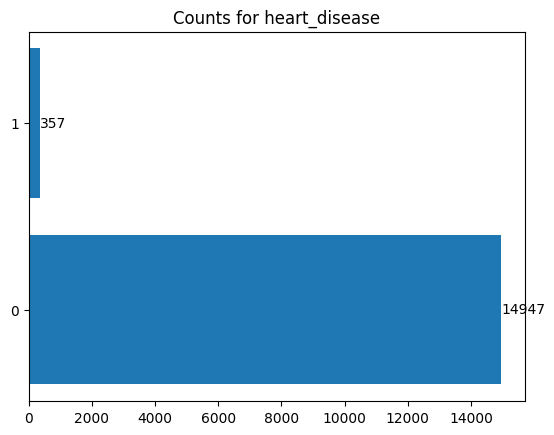

In [69]:
plot_counts('heart_disease')

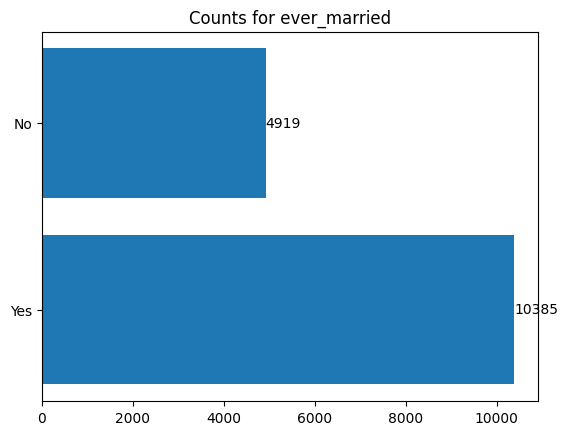

In [70]:
plot_counts('ever_married')

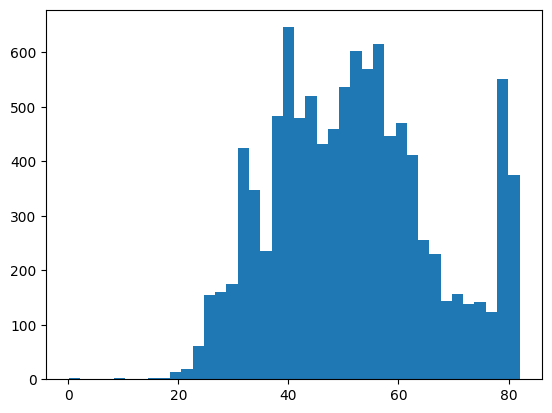

In [73]:
_ = plt.hist(df.filter(pl.col('ever_married') == 'Yes').select(pl.col('age')), bins=40)

There are some kids marked as married

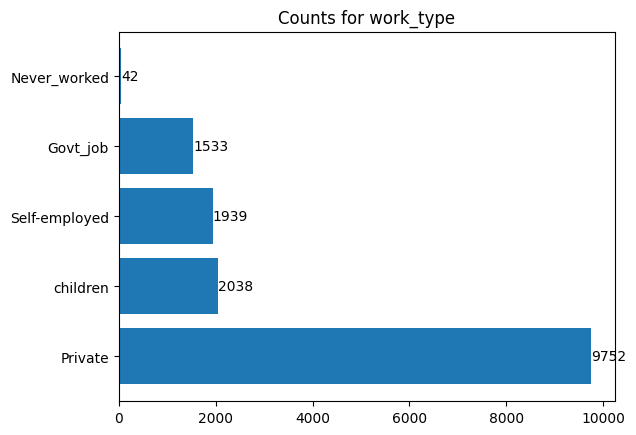

In [75]:
plot_counts('work_type')

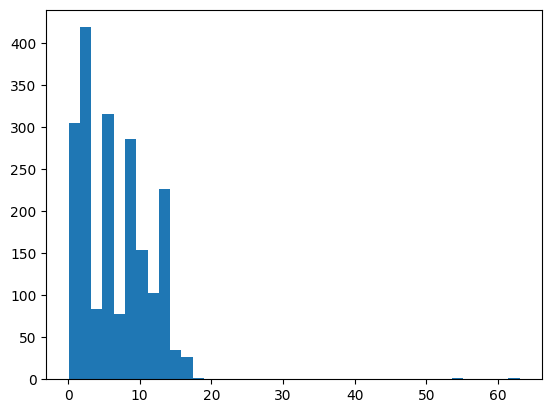

In [78]:
_ = plt.hist(df.filter(pl.col('work_type') == 'children').select(pl.col('age')), bins=40)

There are some old people incorrectly assigned to work type.

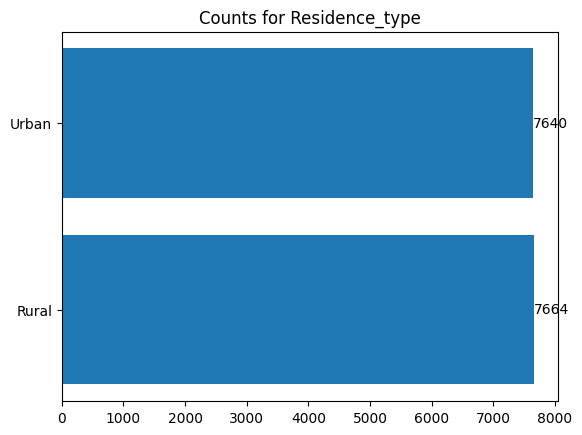

In [80]:
plot_counts('Residence_type')

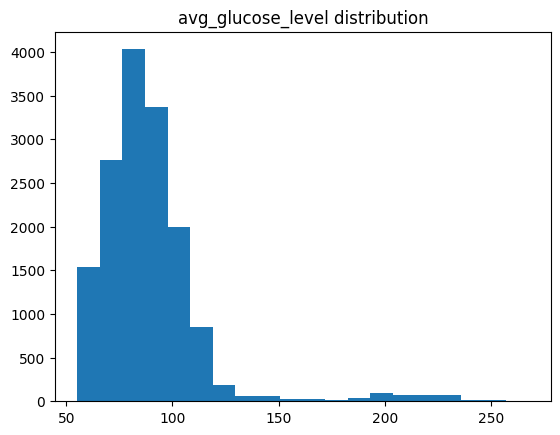

In [82]:
plot_histogram('avg_glucose_level', bins=20)

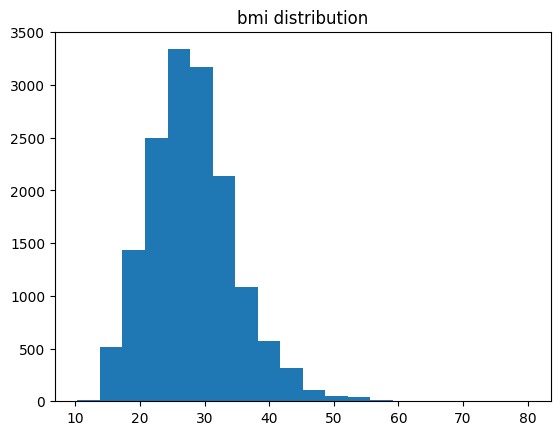

In [83]:
plot_histogram('bmi', bins=20)

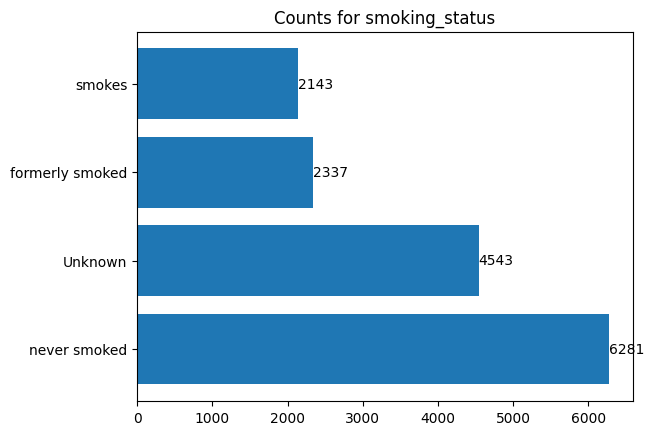

In [84]:
plot_counts('smoking_status')

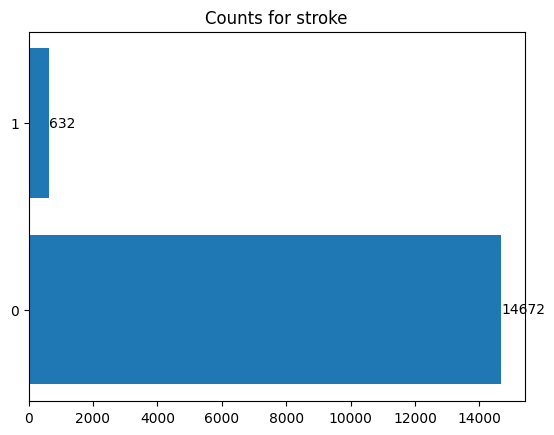

In [85]:
plot_counts('stroke')